### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

***
# <font color=red>Customer Segmentation for Retail Use Case</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Advanced Data Services Team </font></p>

***



## Overview:

This notebook will focus on the exploratory data analysis, outlier treatment/removal and advanced clustering techniques. The dataset contains over 900k transactional line items with purchase related atttributes such as sales amount.

Given the task of developing a deeper understanding by way of segmentation, we will deploy an advanced clustering technique to group similair behaving customers together. 

---

## Business Use:

With the increase in business's ability to easily capture large volumes of data, many companies now have the ability to go beyond the general customer/marketing analysis. A robust customer segmentation can help business discover many unknow features of their customer base. By leveraging machine learning to better understand a customer, a business can further drive their business and growth with the right customer marketing plan, loyalty reward program or by accuratly being able to make reasonable adjustments to a pricing model.


This demonstration will show how we can use some basic measures and statistics, such as the RFM calculations, to develop an advanced customer segmentation using Oracle Cloud Data Science. 

---

## Objectives:


By the end of this tutorial, we will have a thorough overview of the explanations algorithms available in ADS for a regression problem:
 - <a href='#dataset'>Dataset</a> An overview of the dataset we are using in this notebook and a quick exploration of the dataset.
 - <a href='#model_training'>Model Training</a> Train three regressor models to evaluate and explain. 
 - <a href='#eval'>Model Evaluation</a> Before looking into interpretation algorithms we will evaluate our model on a test/holdout dataset. We will look at the typical plots for a regression problems, including Observed vs Predicted, Residuals Q-Q Plot, Residuals vs Predicted, etc.  
 - <a href='#explanations'>Model Explanations</a> This section is the crux of this notebook. We will cover multiple methods and diagnostics including: 
      - <a href='#adsexplainer'>ADSExplainer</a> An overview of the ADSExplainer Object that is needed to leverage the explanations API. 
      - <a href='#global'>Global Explanations</a>
          - <a href='#featureimportance'>Feature Importance</a>
          - <a href='#pdp_ice'>Feature Dependence Explanations (PDP and ICE)</a>
      - <a href='#local'>Local Explanations</a>
          
 ***
 <a id='setup'></a>


This notebook will be useful to you if you want to understand how to:

  - Use ADS to import data from Object Storage
  - Construct ADS models from custom models.
  - **(Focus of this notebook)** Use ADS's model explainer to provide additional insight into how the model works.
  
First, lets import the necessary packages

In [165]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import logging
import os
import cx_Oracle
import pickle

import seaborn as sns
import matplotlib.pyplot as plt


logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest



In [166]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [167]:
%env TNS_ADMIN=/home/datascience/your_wallet_folder
%env ADW_SID=your_db_name_low
%env ADW_USER=your_username
%env ADW_PASSWORD=your_password

!echo exit | sqlplus ${ADW_USER}/${ADW_PASSWORD}@${ADW_SID}

uri=f'oracle+cx_oracle://{os.environ["ADW_USER"]}:{os.environ["ADW_PASSWORD"]}@{os.environ["ADW_SID"]}'

env: TNS_ADMIN=/home/datascience/jmadw_wallet
env: ADW_SID=jmadw_high
env: ADW_USER=admin
env: ADW_PASSWORD=Welcome#1234

SQL*Plus: Release 19.0.0.0.0 - Production on Thu Mar 4 15:06:42 2021
Version 19.6.0.0.0

Copyright (c) 1982, 2019, Oracle.  All rights reserved.

Last Successful login time: Thu Mar 04 2021 00:37:14 +00:00

Connected to:
Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.5.0.0.0

SQL> Disconnected from Oracle Database 19c Enterprise Edition Release 19.0.0.0.0 - Production
Version 19.5.0.0.0


<a id='dataset'></a>
# Ingesting Data from Oracle Object Storage

We start by reading in the retail dataset from an object storage bucket. The ADS DatasetFactory module allows us to easily connect and import data from object storage. The .set_target() API can be used to specity the name of the target column in the dataset, however, for our unsupervised learning task.

 
</font>


In [168]:
try:
    if df is not None:
        del df
except NameError:
    pass

df = DatasetFactory.open("~/Customer_Transactions_masked.csv",parse_dates=['transaction_dt','first_transaction','last_transaction']).to_pandas_dataframe()

df.columns = map(str.lower, df.columns)


The retail customer data has successfully been loaded. We have several key features in this dataset including the customer # of transactions, sales amount, quantity and how many promotions they have used over a 30 month period.

In [17]:
df.sort_values(by=['customer','transaction_dt']).head()

,customer,transaction_cnt,transaction_dt,last_transaction,first_transaction,sales_amount,quantity
447352,4657670,1,2020-06-30,2020-06-30,2020-01-03,10.48,5
617551,4657683,2,2020-06-15,2020-07-04,2020-01-05,11.31,6
617552,4657683,2,2020-07-04,2020-07-04,2020-01-05,14.15,7
725840,4657691,8,2020-06-21,2020-07-10,2020-01-08,0.22,1
725841,4657691,8,2020-06-21,2020-07-10,2020-01-08,0.79,1


There is a presence of some suspect data points. Specifically, we have large negative sales amounts and quantity purchased of 0 for some customers.

In [18]:
df.drop(columns=['customer']).describe()

,transaction_cnt,sales_amount,quantity
count,947324.000000,947324.000000,947324.000000
mean,31.357836,18.879091,8.692941
std,49.978663,28.526419,12.787697
min,1.000000,-500.000000,0.000000
25%,6.000000,2.390000,1.000000
50%,15.000000,14.020000,6.000000
75%,36.000000,26.400000,13.000000
max,619.000000,3486.410000,1484.000000


Here, we filter the data to only consider  customers who have purchased at least 1 item. We will also create two new columms:
"new customer" to indicate if a customer is new based on whether their first purchase occured over the last 30 days and "price_per_item" to reflect the average price per item customers pay.

In [19]:
min_transaction = min(df.transaction_dt)

df = df[df.quantity>0]

def new_customer(first):
    if first>=min_transaction:
        return 1
    else:
        return 0
    
df['new_customer'] = df.apply(lambda x:new_customer(x['first_transaction']),axis=1)
df['price_per_item'] = round(df.sales_amount/df.quantity, 2)
df['days_from_last_transaction']=(pd.Timestamp('2020-07-20')-df.transaction_dt).dt.days
df['days_from_last_transaction'] = df.days_from_last_transaction
df['days_since_first']=(pd.Timestamp('2020-07-20')-df.first_transaction).dt.days
df['days_since_first'] = df.days_since_first
df = df[df.sales_amount>=1]

In [20]:
df.head()

,customer,transaction_cnt,transaction_dt,last_transaction,first_transaction,sales_amount,quantity,new_customer,price_per_item,days_from_last_transaction,days_since_first
0,4757638,3,2020-06-15,2020-07-06,2020-01-01,102.03,41,0,2.49,35,201
1,4757638,3,2020-07-04,2020-07-06,2020-01-01,57.92,21,0,2.76,16,201
2,4757638,3,2020-07-06,2020-07-06,2020-01-01,55.83,27,0,2.07,14,201
3,104658040,1,2020-06-18,2020-06-18,2020-04-23,32.77,15,0,2.18,32,88
4,104658044,5,2020-06-15,2020-07-10,2020-04-06,21.18,9,0,2.35,35,105


### Recency, Frequency and Monetary

A group of useful measures in the retail space are the receny, frequency and monetary metrics. Recency is defined as number of days since the previous transaction. Frequency is the number of transactions over a period of time. Monetary is the total of sales amount of a period of time. Mathematically, they are defined as:

$Recency=\min(\max(Transaction_{x_i}) - Transaction_{x_i}),\text{where}\ x_i\ \text{is the}\ i^{th}\ \text{customer}$\
$Frequency=\sum_{i=1}^{n} Transaction_{x_i}, \text{where}\ x_i\ \text{is the}\ i^{th} \ \text{customer transaction}$\
$Monetary=\sum_{i=1}^{n} Sales Amount_{x_i}, \text{where}\ x_i\ \text{is the}\ i^{th} \ \text{customer transaction}$




In [21]:
## Calcluating the RFM metrics
try:
    if RFM is not None:
        del RFM
except NameError:
    pass


RFM={'days_from_last_transaction': lambda x:x.min(),
     'transaction_dt':lambda x:x.count(),
     'sales_amount': lambda x:x.sum(),
     'quantity': lambda x:x.mean(),
     'price_per_item':lambda x:round(x.median(),2)}
RFM=df.groupby(['customer','new_customer','days_since_first']).agg(RFM).reset_index()
RFM.columns=['customer','new_customer','days_since_first','recency','frequency','monetary','quantity','price_per_item']



distributed.comm.inproc - WARNING - Closing dangling queue in <InProc  local=inproc://10.0.2.6/1986/1 remote=inproc://10.0.2.6/1986/10>


In [22]:
RFM.head()

,customer,new_customer,days_since_first,recency,frequency,monetary,quantity,price_per_item
0,4657670,0,199,20,1,10.48,5.0,2.10
1,4657683,0,197,16,2,25.46,6.5,1.95
2,4657691,0,194,10,5,62.88,6.4,2.00
3,4657693,0,189,23,1,10.29,6.0,1.72
4,4657697,0,38,18,7,50.57,3.0,2.27


A quick statistical view of the data shows shome strange monetary values where some customers have total negative sales values

In [23]:
RFM.drop(columns=['customer']).describe()

,new_customer,days_since_first,recency,frequency,monetary,quantity,price_per_item
count,135134.000000,135134.000000,135134.000000,135134.000000,135134.000000,135134.000000,135134.000000
mean,0.136909,147.029800,13.359636,6.231422,132.203432,11.619908,2.192208
std,0.343752,66.234557,8.224982,10.050552,319.935832,9.778320,0.944206
min,0.000000,5.000000,5.000000,1.000000,1.000000,1.000000,0.250000
25%,0.000000,100.000000,7.000000,2.000000,35.150000,7.000000,1.950000
50%,0.000000,186.000000,10.000000,3.000000,72.790000,11.000000,2.080000
75%,0.000000,198.000000,18.000000,7.000000,143.337500,14.500000,2.200000
max,1.000000,201.000000,35.000000,512.000000,39788.660000,634.000000,76.060000


Given that sales and revenue are the driving force of virtually all business we want to make sure we include supporting statistics around the $Monetary$ attribute to aid in our cluster analysis. For this, we derive the $\text{min, max and sample standard deviation}$ of customer sales.

In [24]:
## defining several statistics around monetary attribute
def mon_metrics(x):
    d = {}
    d['monetary_min'] = x['sales_amount'].min()
    d['monetary_max'] = x['sales_amount'].max()
    d['monetary_median'] = x['sales_amount'].median()
    d['monetary_std'] = x['sales_amount'].std(ddof=0)
    
    return pd.Series(d, index=['monetary_min','monetary_max','monetary_median','monetary_std'])

RFM = RFM.merge((df.groupby('customer').apply(mon_metrics).reset_index()), on='customer', how='inner')

In [25]:
def freq_metrics(x):
    d = {}
    d['frequency_min'] = x['frequency'].min()
    d['frequency_max'] = x['frequency'].max()
    d['frequency_median'] = x['frequency'].median()
    d['frequency_std'] = x['frequency'].std(ddof=0)
    
    return pd.Series(d, index=['frequency_min','frequency_max','frequency_median','frequency_std'])

RFM = RFM.merge((RFM.groupby('customer').apply(freq_metrics).reset_index()), on='customer', how='inner')

In [26]:
RFM.to_pickle('./RFM.pkl')

In [27]:
RFM.head()

,customer,new_customer,days_since_first,recency,frequency,monetary,quantity,price_per_item,monetary_min,monetary_max,monetary_median,monetary_std,frequency_min,frequency_max,frequency_median,frequency_std
0,4657670,0,199,20,1,10.48,5.0,2.10,10.48,10.48,10.48,0.000000,1.0,1.0,1.0,0.0
1,4657683,0,197,16,2,25.46,6.5,1.95,11.31,14.15,12.73,1.420000,2.0,2.0,2.0,0.0
2,4657691,0,194,10,5,62.88,6.4,2.00,1.00,34.65,11.25,12.143529,5.0,5.0,5.0,0.0
3,4657693,0,189,23,1,10.29,6.0,1.72,10.29,10.29,10.29,0.000000,1.0,1.0,1.0,0.0
4,4657697,0,38,18,7,50.57,3.0,2.27,1.69,20.44,4.19,7.031200,7.0,7.0,7.0,0.0


Looking at the Monetary values, we see heavy skewness suggesting in quite a few outliers

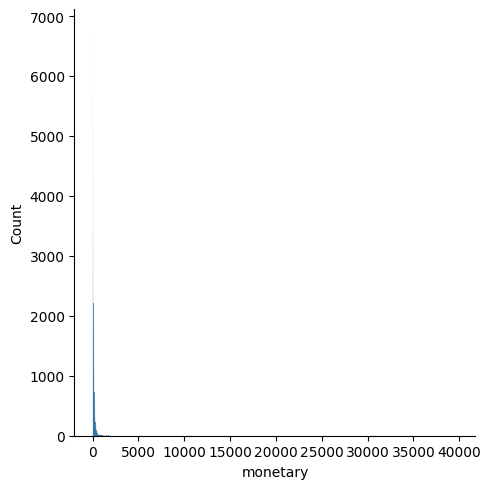

In [183]:
sns.displot(RFM.monetary)

Given the extremeness of the outliers, we will use an Isolation Forest algorithm to help find a patter.

In [28]:
RFM = pickle.load(open('RFM.pkl','rb'))
iForest = IsolationForest(n_estimators=100, max_samples=256, contamination=0.1)
iForest.fit(RFM.drop(columns=['customer','new_customer']))
RFM['outlier_score'] = iForest.predict(RFM.drop(columns=['customer','new_customer']))

In [29]:
RFM[RFM.outlier_score==1].sort_values(by='monetary',ascending=False).head()

,customer,new_customer,days_since_first,recency,frequency,monetary,quantity,price_per_item,monetary_min,monetary_max,monetary_median,monetary_std,frequency_min,frequency_max,frequency_median,frequency_std,outlier_score
22527,4814353,0,201,7,15,659.82,18.466667,2.47,20.00,58.85,42.990,9.162063,15.0,15.0,15.0,0.0,1
44632,4966157,0,199,6,16,654.58,16.375000,2.27,5.75,59.76,44.505,13.496183,16.0,16.0,16.0,0.0,1
16436,4772344,0,201,6,18,645.93,17.222222,2.06,20.50,46.75,36.000,6.143764,18.0,18.0,18.0,0.0,1
6074,4700076,0,200,5,16,642.20,17.437500,2.39,12.36,61.27,38.825,11.985942,16.0,16.0,16.0,0.0,1
42701,4953368,0,200,9,17,620.95,17.352941,2.10,18.20,63.09,31.180,15.485708,17.0,17.0,17.0,0.0,1


Monetary values seem much more reasonable

Text(0.5, 1.0, 'Distribution of Monetary Attribute')

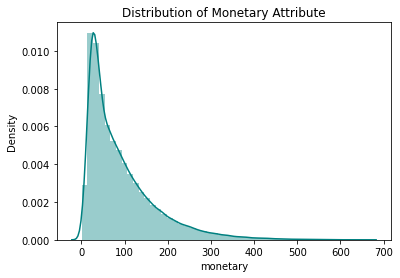

In [30]:
sns.distplot(RFM[RFM.outlier_score==1].monetary)
plt.title('Distribution of Monetary Attribute')

## Unsupervised Learning Task
In segmentation, often a K-means algorithm is deployed. But one of the major drawbacks of using K-means clustering algorithm is that each customer would be assigned to one and only one cluster. For this instead we look to use something more robust such as a $\text{Gaussian Mixture Models Clustering Algorithm}$.

#### Gaussian Mixture Model
We assume that are data can be represented as several $\text{Gaussian}$ distributions. We also assume we do not know the parameters that make up each of these distributions. To estimate we use the $\text{Expectation-Maximization Algorithm}$ to estimate our parameters. That is, we seek to estimate,
$\theta_i=\{\mu_1,...,\mu_N,\sigma_1,...,\sigma_N,\pi_1,...,\pi_N\}, \text{where} \ \mu_i \ \text{is the mean of a Gaussian distribution}, \sigma_i \ \text{is the Gaussian distribution standard deviation, related to the ith feature}$.

Using the Sklearn Gaussian Mixture algorithm, we run through several iterations to find an optimized BIC score. We find that the lowest BIC value was found using a "full" covariance matrix, 14 components (# of Gaussians) and a "kmeans" intitialization of weights, means and precisions.

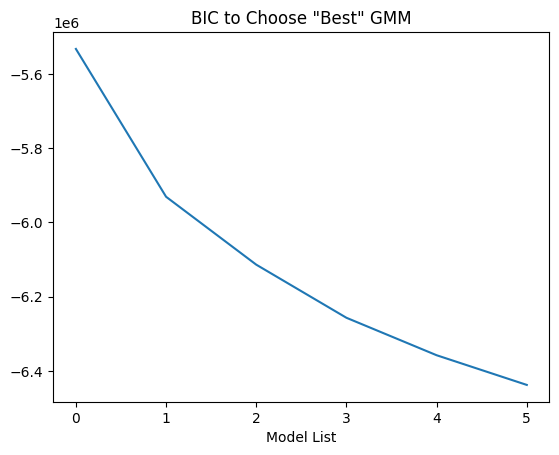

In [169]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
import pickle
from sklearn.preprocessing import normalize


X = RFM[(RFM.outlier_score==1) & (RFM.new_customer==0)]
X = RFM[['recency','frequency','monetary','frequency_max','monetary_max','frequency_std','monetary_std','frequency_max','frequency_min']]
X_scale=normalize(X)


n_components = np.arange(3, 9)
covariance_type = ['diag']
init_params=['kmeans','random']
GMM_Models = [GaussianMixture(n, c, random_state=0, init_params='kmeans').fit(X_scale)
          for n in n_components for c in covariance_type]

plt.plot([m.bic(X_scale) for m in GMM_Models], label='BIC')
plt.title('BIC to Choose "Best" GMM')
plt.xlabel('Model List');

In [20]:
GMM_Models[3]

GaussianMixture(covariance_type='diag', n_components=6, random_state=0)

In [21]:
len(RFM[RFM.outlier_score==1])

121620

In [31]:
from sklearn.mixture import GaussianMixture
import pickle
from sklearn.preprocessing import normalize

X = RFM[(RFM.outlier_score==1) & (RFM.new_customer==0)]
X = RFM[['recency','frequency','monetary','monetary_max','monetary_std','monetary_min','monetary_median']].values
X_scale=normalize(X)

## Creating the GMM instance 
GMM = GaussianMixture(init_params='kmeans', n_components=10,random_state=0,covariance_type='diag')

GMM_clusters=GMM.fit_predict(X_scale)
GMM_scores = GMM.predict_proba(X_scale)

GMM_preds = GMM.predict(X_scale)

## Retrieving Cluster Labels for Interpretation
GMM_y=GMM_clusters
GMM_y=GMM_clusters+1


    
cluster=pd.DataFrame(GMM_y)
scores = pd.DataFrame(GMM_scores)
RFM['GMM_Segmentation']=cluster
RFM = RFM[RFM.GMM_Segmentation.notnull()]


Inspecting the average values on the features we trained our GMM on we see some clear patterns. 
To account for customers who were new shoppers we have put those whose first purchase with the business was within 30 days and have only 1 transaction into their own segment. We can begin group similiar segments together. For example, Customer Segment

In [32]:
agg={'recency':lambda x:x.mean(),
     'monetary':lambda x:x.mean(),
     'frequency':lambda x:x.mean(),
     'quantity':lambda x:x.mean(),
     'customer':lambda x:x.nunique()}
RFM_Agg=RFM[(RFM.outlier_score==1) & (RFM.new_customer==0)].groupby('GMM_Segmentation').agg(agg).reset_index().sort_values(by=['monetary','frequency','recency'])
RFM_Agg.columns=['Customer Segment', 'Recency', 'Monetary', 'Frequency', 'Quantity','Customer_Cnt']
RFM_Agg

,Customer Segment,Recency,Monetary,Frequency,Quantity,Customer_Cnt
6,7,27.050139,13.463972,1.050693,6.424377,3610
1,2,26.912348,23.018160,1.000000,11.424805,5499
9,10,21.222644,29.029827,1.000000,13.899724,5794
2,3,11.298830,32.143154,1.000000,15.094633,4956
8,9,16.770800,45.102449,3.336660,6.865867,13726
3,4,14.224370,56.860131,2.000000,13.692069,12105
4,5,10.741467,96.138427,3.532817,13.162594,19746
5,6,10.059288,104.927045,8.471058,6.198113,11402
0,1,7.919397,171.606409,6.678050,12.476754,17394
7,8,6.699604,250.393102,14.426472,8.546869,10343


We can create labels to add business value

In [33]:
def segments(clusters):
    if (clusters == 7) or (clusters==2) or clusters==10 or clusters==3:
        return 'Low Value'
    elif (clusters == 9) or clusters == 4:
        return 'Potential'
    elif clusters == 5 or clusters == 6:
        return 'Valuable'
    elif clusters == 1:
        return 'Very Valuable'
    elif clusters == 8:
        return 'VIP'
    
RFM['Customer Segments'] = RFM.apply(lambda x:segments(x['GMM_Segmentation']),axis=1)
    

Text(0.5, 1.0, 'Monetary Distribution by Customer Segment')

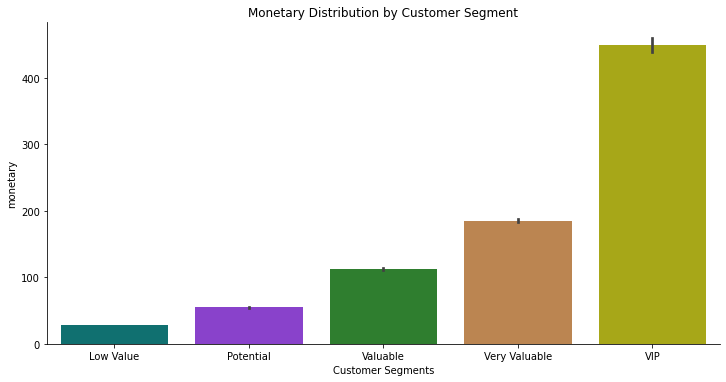

In [34]:
sns.catplot(x='Customer Segments',y='monetary',data=RFM.sort_values(by='monetary'), height=5, aspect=2, kind='bar')
plt.title('Monetary Distribution by Customer Segment')

In [176]:
RFM.head()

,customer,new_customer,days_since_first,recency,frequency,monetary,quantity,price_per_item,monetary_min,monetary_max,monetary_median,monetary_std,frequency_min,frequency_max,frequency_median,frequency_std,outlier_score,GMM_Segmentation,Customer Segments
0,4657670,0,199,20,1,10.48,5.0,2.10,10.48,10.48,10.48,0.000000,1.0,1.0,1.0,0.0,1,7,Low Value
1,4657683,0,197,16,2,25.46,6.5,1.95,11.31,14.15,12.73,1.420000,2.0,2.0,2.0,0.0,1,9,Potential
2,4657691,0,194,10,5,62.88,6.4,2.00,1.00,34.65,11.25,12.143529,5.0,5.0,5.0,0.0,1,9,Potential
3,4657693,0,189,23,1,10.29,6.0,1.72,10.29,10.29,10.29,0.000000,1.0,1.0,1.0,0.0,1,7,Low Value
4,4657697,0,38,18,7,50.57,3.0,2.27,1.69,20.44,4.19,7.031200,7.0,7.0,7.0,0.0,1,9,Potential
